# Import libraries and load dataset

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


def import_aquifer(name):
    if name=="auser":
        return pd.read_csv("../input/acea-water-prediction/Aquifer_Auser.csv")

/kaggle/input/acea-water-prediction/Aquifer_Doganella.csv
/kaggle/input/acea-water-prediction/Aquifer_Auser.csv
/kaggle/input/acea-water-prediction/Water_Spring_Amiata.csv
/kaggle/input/acea-water-prediction/datasets_description.ods
/kaggle/input/acea-water-prediction/Lake_Bilancino.csv
/kaggle/input/acea-water-prediction/datasets_description.xlsx
/kaggle/input/acea-water-prediction/Water_Spring_Madonna_di_Canneto.csv
/kaggle/input/acea-water-prediction/Aquifer_Luco.csv
/kaggle/input/acea-water-prediction/Aquifer_Petrignano.csv
/kaggle/input/acea-water-prediction/Water_Spring_Lupa.csv
/kaggle/input/acea-water-prediction/River_Arno.csv


# Functions for preprocessing data

**Scegliere il pozzo**
Abbiamo numerose colonne che permettono di stimare il livello di acqua. Cerchiamo di utilizzarne una sola, prendendo quella che massimizza la varianza e la correlazione con gli altri pozzi

                           Depth_to_Groundwater_LT2  Depth_to_Groundwater_SAL  \
Depth_to_Groundwater_LT2                   1.000000                  0.528740   
Depth_to_Groundwater_SAL                   0.528740                  1.000000   
Depth_to_Groundwater_PAG                   0.099945                  0.687332   
Depth_to_Groundwater_CoS                   0.130485                  0.575605   
Depth_to_Groundwater_DIEC                  0.193430                  0.693203   

                           Depth_to_Groundwater_PAG  Depth_to_Groundwater_CoS  \
Depth_to_Groundwater_LT2                   0.099945                  0.130485   
Depth_to_Groundwater_SAL                   0.687332                  0.575605   
Depth_to_Groundwater_PAG                   1.000000                  0.796094   
Depth_to_Groundwater_CoS                   0.796094                  1.000000   
Depth_to_Groundwater_DIEC                  0.767976                  0.712223   

                          

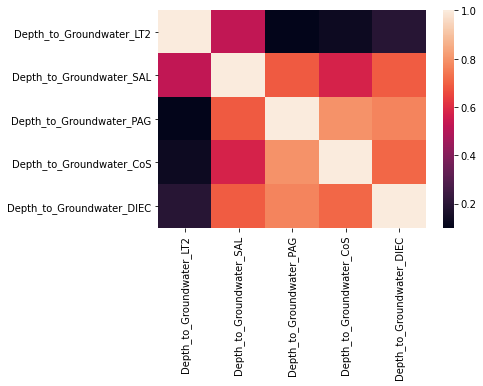

In [6]:
aquifer = import_aquifer("auser")
wells_name = [col for col in aquifer.columns if col[0:6]=='Depth_']
wells = aquifer[wells_name]
wells_corr = wells.corr(method='pearson')
sns.heatmap(wells_corr)
print(wells_corr)
print("Between correlations:")
print(wells_corr.mean())
print("Standard deviation of values")
print(wells.std())

(735964.0, 736330.0)

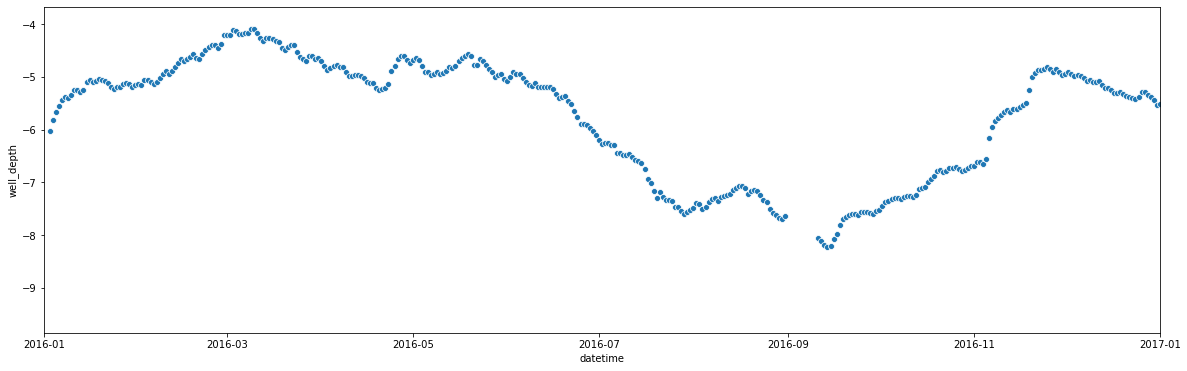

In [3]:
def extract_col(df, substr):
    return [col for col in df.columns if col[0:len(substr)]==substr]

#import the dataset
import datetime


    
def format_date(aquifer):
    #Formatting date
    aquifer["year"] = pd.DatetimeIndex(aquifer['Date']).year
    aquifer["month"] = pd.DatetimeIndex(aquifer['Date']).month
    aquifer["datetime"] = aquifer['Date'].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y') ) #pay attention to date format!
    aquifer['day'] = aquifer['datetime'] - datetime.datetime(1970,1,1)
    aquifer = aquifer.astype({"day": int})
    aquifer["day_of_year"] = aquifer['datetime'].dt.dayofyear
    return aquifer

    


def format_rain(aquifer,days):
    #Calculating total rain
    rain_name = extract_col(aquifer, 'Rainfall_')
    aquifer[rain_name] = aquifer[rain_name].fillna(0)
    aquifer["tot_rain"] = aquifer[rain_name].sum(axis=1)

    #commented graph vor visualise the data
    #sns.scatterplot(data=aquifer, y="tot_rain", x="day", hue="year" )
    #For starting data there is no record, which ones exactly?
    yearly_rain = aquifer.groupby("year")["tot_rain"].sum()
    #electing only data with recorded rain (2006-2020)
    recorded_years = yearly_rain.index[yearly_rain > yearly_rain.max()/10]
    aquifer = aquifer[aquifer.year.isin(recorded_years)].copy()
    #Add additional columns for old rain
    max_day_before = days #select how long keep old rain record
    for d in range(max_day_before):
        aquifer["tot_rain_"+str(d)] = aquifer["tot_rain"].shift(d) 
    return aquifer



def format_well(aquifer, well_name, days):
    #Choose which well investigate:
    # well_name = "Depth_to_Groundwater_CoS"
    #Add a column for using standard labels
    aquifer["well_depth"] = aquifer[well_name]
    #Fill not recorded depth with 0 (actually depth is never 0)
    aquifer["well_depth"] = aquifer["well_depth"].fillna(0)

    #add the depth level of the day bafore
    aquifer["old_well_depth"] = aquifer["well_depth"].shift(days)
    #subtract for get the difference of depth: delta>0 when there is MORE water in the aquifer
    aquifer["delta_depth"] = aquifer["well_depth"] - aquifer["old_well_depth"]
    return aquifer

aquifer = import_aquifer("auser")
max_day_before = 10
delta_days = 5
aquifer = format_date(aquifer)
aquifer = format_rain(aquifer,max_day_before)
aquifer = format_well(aquifer,"Depth_to_Groundwater_CoS", delta_days)
#Delete initial rows with Nan values
aquifer = aquifer.iloc[max_day_before-1:]


#commented graph vor visualise the data
#sns.scatterplot(data=aquifer, y="well_depth", x="day", hue="year" )

# There are lots of non-recorded value. As we are mainly interested in estimating delta_depth
# fill non recorded days by interpolation doesn't seem a good strategy, so we simply discard them
aquifer = aquifer[aquifer["well_depth"]*aquifer["old_well_depth"]>0] #remember depth<0 for real records

# graph vor visualise final data (now it's okay)
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
sns.scatterplot(data=aquifer, y="well_depth", x="datetime" )
axs.set_xlim(datetime.datetime(2016,1,1),datetime.datetime(2017,1,1))


# Check data integrity

In [23]:
# We check missing values
for df in (aquifer,):
    print("_____________________")
    for col in df.columns:
        print("NaN values in %s = %2.2f%% " % (col, 100*df[col].isnull().sum()/df.shape[0]))


_____________________
NaN values in Date = 0.00% 
NaN values in Rainfall_Gallicano = 0.00% 
NaN values in Rainfall_Pontetetto = 0.00% 
NaN values in Rainfall_Monte_Serra = 0.00% 
NaN values in Rainfall_Orentano = 0.00% 
NaN values in Rainfall_Borgo_a_Mozzano = 0.00% 
NaN values in Rainfall_Piaggione = 0.00% 
NaN values in Rainfall_Calavorno = 0.00% 
NaN values in Rainfall_Croce_Arcana = 0.00% 
NaN values in Rainfall_Tereglio_Coreglia_Antelminelli = 0.00% 
NaN values in Rainfall_Fabbriche_di_Vallico = 0.00% 
NaN values in Depth_to_Groundwater_LT2 = 8.98% 
NaN values in Depth_to_Groundwater_SAL = 13.08% 
NaN values in Depth_to_Groundwater_PAG = 21.42% 
NaN values in Depth_to_Groundwater_CoS = 0.00% 
NaN values in Depth_to_Groundwater_DIEC = 36.10% 
NaN values in Temperature_Orentano = 0.00% 
NaN values in Temperature_Monte_Serra = 0.00% 
NaN values in Temperature_Ponte_a_Moriano = 0.00% 
NaN values in Temperature_Lucca_Orto_Botanico = 0.00% 
NaN values in Volume_POL = 0.00% 
NaN values i

# Testare l'efficacia del modello
L'idea più semplice è quella di calcolare il rapporto tra la radice dell'errore quadratico medio e la deviazione standard delle y (dove 1 = sto tirando a caso, 0 = nessun errore).
Questo approccio è confermato dall'utilizzo di R^2 (https://it.wikipedia.org/wiki/Coefficiente_di_determinazione) in statistica, e dal NSE in idrologia https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient

(ricordarsi di fare 1 - x^2 per passare da un indicatore all'altro) 

EDIT: Ho modificato il codice mettendo direttamente l'R^2

In [ ]:
# Some functions for measuring performance of the model:
def normalize(X):
    return (X - 0)/X.std()

def get_std_errors(X_old):
    X = X_old.copy()
    X["intercept"] = 1
    df = X.transpose().dot(X)
    inv = pd.DataFrame(np.linalg.pinv(df.values), df.columns, df.index)
    return np.sqrt(np.diag(inv))

# Print coefficients and Z score as a formatted table
def get_coef_table(reg, features):
    format = "%-20s | %+2.3f | %+2.3f"
    format_title = "%-20s | %6s | %6s"
    print (format_title %("feature","coef","Z score"))
    print ("-"*38)
    for i in range((len(features))):
        print(format%(features[i][:20],reg.coef_[i],reg.coef_[i]/std_errors[i]))
    print("Intercept:\n", reg.intercept_)

# Study the performance of the model on different lapses of time

Forecast on 18 days.    R^2 = 0.744
feature              |   coef | Z score
--------------------------------------
tot_rain_0           | +0.022 | +1.159
tot_rain_1           | +0.038 | +1.849
tot_rain_2           | +0.035 | +1.725
tot_rain_3           | +0.045 | +2.214
tot_rain_4           | +0.043 | +2.091
tot_rain_5           | +0.045 | +2.176
tot_rain_6           | +0.054 | +2.635
tot_rain_7           | +0.050 | +2.441
tot_rain_8           | +0.052 | +2.536
tot_rain_9           | +0.045 | +2.181
tot_rain_10          | +0.054 | +2.640
tot_rain_11          | +0.043 | +2.111
tot_rain_12          | +0.048 | +2.370
tot_rain_13          | +0.053 | +2.577
tot_rain_14          | +0.048 | +2.344
tot_rain_15          | +0.059 | +2.895
tot_rain_16          | +0.051 | +2.508
tot_rain_17          | +0.053 | +2.640
tot_rain_18          | +0.033 | +1.610
tot_rain_19          | +0.026 | +1.367
old_well_depth       | -0.175 | -9.358
Temperature_Monte_Se | -0.189 | -9.216
Intercept:
 -0.873184334065

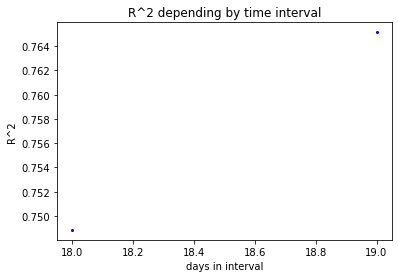

In [58]:
# Study the performance on different lapses of time

r2_test = []
time_interval = list(range(18,20))
for delta_days in time_interval:
    max_day_before = delta_days + 2
    #delta_days = 5
    aquifer = pd.read_csv("../input/acea-water-prediction/Aquifer_Auser.csv")
    aquifer = format_date(aquifer)
    aquifer = format_rain(aquifer,max_day_before)
    aquifer = format_well(aquifer,"Depth_to_Groundwater_CoS", delta_days)
    #Delete initial rows with Nan values
    aquifer = aquifer.iloc[max_day_before-1:]


    #commented graph vor visualise the data
    #sns.scatterplot(data=aquifer, y="well_depth", x="day", hue="year" )

    # There are lots of non-recorded value. As we are mainly interested in estimating delta_depth
    # fill non recorded days by interpolation doesn't seem a good strategy, so we simply discard them
    aquifer = aquifer[aquifer["well_depth"]*aquifer["old_well_depth"]>0]


    # Now we need to separate data in train and test
    # Let's try with a shuffle (read comment below)
    train = aquifer.sample(frac=0.8,random_state=22) #random state is a seed value
    test = aquifer.drop(train.index)
    #We try predict the difference in depth level
    y_train = train["delta_depth"]
    y_test = test["delta_depth"]

    # Extracting features 
    features = extract_col(aquifer, 'tot_rain_') + ["old_well_depth","Temperature_Monte_Serra"]
    #take a subset of features, based on the performance of the total model
    # test error with all features: 0.0508
    # test error with  [0,1,2] features: 0.0516
    #selected_features = [features[i] for i in [0,1,2]]
    #features = extract_col(aquifer, 'Rainfall_') + ["old_well_depth"]
    selected_features = features
    #selected_features = [features[i] for i in [0,1,2]]
    #print("Features extracted: \n",selected_features)


    #extract and normalize training features

    x_train = train[selected_features]
    x_test = test[selected_features]
    x_train = normalize(x_train)
    x_test = normalize(x_test)

    #fitto il modello
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    reg = model.fit(x_train, y_train)
    std_errors = get_std_errors(x_train)
    print("Forecast on %d days.    R^2 = %2.3f"%(delta_days,reg.score(x_test, y_test))) 
    get_coef_table(reg, selected_features)
    
    r2_test.append(1 - np.var(reg.predict(x_test)-y_test)/np.var(y_test))
print(r2_test)
fig, ax = plt.subplots()
plt.scatter(time_interval, r2_test, s=4, c='blue')
ax.set(title='R^2 depending by time interval',
       ylabel='R^2',
       xlabel='days in interval')
plt.show()

Guardando il grafico notiamo che più lungo è l'intervallo di tempo considerato,migliore è la qualità della predizione (R^2 più alto, 100 giorni di pioggia forniti).
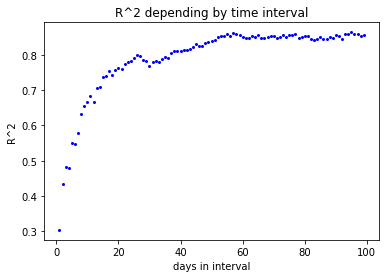
Ciò ha senso, in quanto ci aspettiamo che la somma delle componenti casuali tenda a diventare trascurabile col tempo, rispetto alla somma delle parti calcolabili.
Trovo sorprendente (e sospetto) però che questa rimanga così alta anche con l'aumentare del tempo. Infatti dopo così tanto tempo le informazioni su temperatura e livello iniziale del pozzo sono ben poco significative, e la variazione di livello del pozzo sembrerebbe essere una semplice somma pesata della quantità di pioggia dei giorni precedenti.

Però si esagera un pò, infatti mettendo come unici predittori le pioggie degli ultimi 10 giorni si ottiene il grafico seguente:
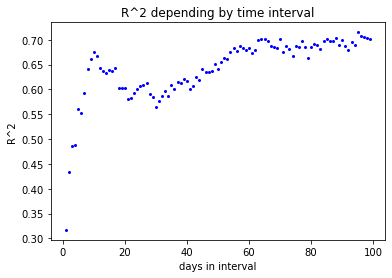
La qualità delle predizioni aumenta per i primi 10 giorni (ha senso) per poi scendere (mancanza di informazioni, ha ancora senso). Dopo 20 giorni però la tendenza si inverte e la qualità della predizione aumenta di nuovo. Perché?
**Ipotesi:** Su intervalli di tempo molto lunghi i fattori stagionali (che hanno un basso contributo sul breve periodo) hanno la meglio sugli altri predittori.
ex: se siamo in agosto, posso facilmente predire che tra due mesi nel pozzo ci sarà molta più acqua, anche senza conoscere il bollettino meteo.

Sarebbe meglio però tenere conto dei fattori stagionali separatamente (e in modo più accurato).

**Proposta:** Possiamo idealmente separare la differenza di livello nel pozzo in tre parti:
*Componenente irregolare*: evidente nella variazione giornaliera, molto difficile o impossibile da calcolare, dovuta alle differenze di orario nella pioggia non registrate (se faccio le misurazioni la sera è diverso che sia piovuto la notte o il pomeriggio), assestamento dell'acqua etc.
*Componente deterministica*: calcolabile a partire da pioggia, temperatura, livello precedente del pozzo etc. Prevalente nel medio termine
*Componente stagionale*: prevalente su considerazioni di lungo periodo (>1 mese)

Il nostro obiettivo diventa quello di ridurre al minimo la prima parte e separare le ultime due, cercando di stimarle il meglio possibile e di trovare i migliori indicatori

Propongo di cominciare dalla componente deterministica, cercando si studiare le previsioni su 10 giorni. Infatti:
 - È circa l'intervallo massimo di tempo su cui si possono avere previsioni metereologiche affidabili;
 - È un periodo abbastanza corto affinché le componenti stagionali abbiano un impatto limitato
 - È un valore in corrispondenza del quale l'aumento di R^2 rallenta considerevolmente
 - È un periodo abbastanza lungo per avere una prevalenza della componente deterministica
 
 Chiaramente la scelta resta abbastanza arbitraria, la prevalenza delle tre componenti andrebbe esaminata in modo più oggettivo. Euristicamente situerei un intervallo ideale di scelta all'incirca tra 5 e 15 giorni


++++++++++++++++++++++++++++++++++++++++
Forecast on 1 days.    R^2 = 0.318
feature              |   coef | Z score
--------------------------------------
tot_rain_0           | +0.024 | +1.278
tot_rain_1           | +0.012 | +0.630
tot_rain_2           | +0.005 | +0.231
tot_rain_3           | +0.002 | +0.076
tot_rain_4           | +0.002 | +0.113
tot_rain_5           | +0.002 | +0.080
tot_rain_6           | +0.001 | +0.059
tot_rain_7           | +0.002 | +0.087
tot_rain_8           | +0.000 | +0.014
tot_rain_9           | +0.001 | +0.043
tot_rain_10          | -0.000 | -0.011
tot_rain_11          | +0.001 | +0.044
tot_rain_12          | -0.000 | -0.013
tot_rain_13          | -0.002 | -0.080
tot_rain_14          | +0.002 | +0.105
tot_rain_15          | +0.001 | +0.055
tot_rain_16          | +0.002 | +0.084
tot_rain_17          | +0.000 | +0.013
tot_rain_18          | -0.001 | -0.028
tot_rain_19          | +0.000 | +0.018
tot_rain_20          | -0.001 | -0.065
tot_rain_21          | +0.

++++++++++++++++++++++++++++++++++++++++
Forecast on 9 days.    R^2 = 0.664
feature              |   coef | Z score
--------------------------------------
tot_rain_0           | +0.025 | +1.289
tot_rain_1           | +0.035 | +1.713
tot_rain_2           | +0.043 | +2.137
tot_rain_3           | +0.040 | +1.972
tot_rain_4           | +0.045 | +2.217
tot_rain_5           | +0.044 | +2.191
tot_rain_6           | +0.051 | +2.520
tot_rain_7           | +0.055 | +2.721
tot_rain_8           | +0.044 | +2.173
tot_rain_9           | +0.029 | +1.442
tot_rain_10          | +0.014 | +0.709
tot_rain_11          | +0.013 | +0.658
tot_rain_12          | +0.009 | +0.466
tot_rain_13          | +0.008 | +0.408
tot_rain_14          | +0.008 | +0.399
tot_rain_15          | +0.005 | +0.276
tot_rain_16          | +0.005 | +0.261
tot_rain_17          | +0.002 | +0.099
tot_rain_18          | +0.005 | +0.261
tot_rain_19          | +0.002 | +0.106
tot_rain_20          | +0.002 | +0.090
tot_rain_21          | +0.

++++++++++++++++++++++++++++++++++++++++
Forecast on 17 days.    R^2 = 0.759
feature              |   coef | Z score
--------------------------------------
tot_rain_0           | +0.025 | +1.298
tot_rain_1           | +0.027 | +1.341
tot_rain_2           | +0.043 | +2.092
tot_rain_3           | +0.042 | +2.057
tot_rain_4           | +0.048 | +2.359
tot_rain_5           | +0.043 | +2.146
tot_rain_6           | +0.052 | +2.548
tot_rain_7           | +0.049 | +2.367
tot_rain_8           | +0.048 | +2.346
tot_rain_9           | +0.051 | +2.529
tot_rain_10          | +0.045 | +2.175
tot_rain_11          | +0.054 | +2.637
tot_rain_12          | +0.050 | +2.414
tot_rain_13          | +0.047 | +2.279
tot_rain_14          | +0.052 | +2.541
tot_rain_15          | +0.053 | +2.633
tot_rain_16          | +0.052 | +2.574
tot_rain_17          | +0.034 | +1.691
tot_rain_18          | +0.019 | +0.940
tot_rain_19          | +0.015 | +0.735
tot_rain_20          | +0.010 | +0.492
tot_rain_21          | +0

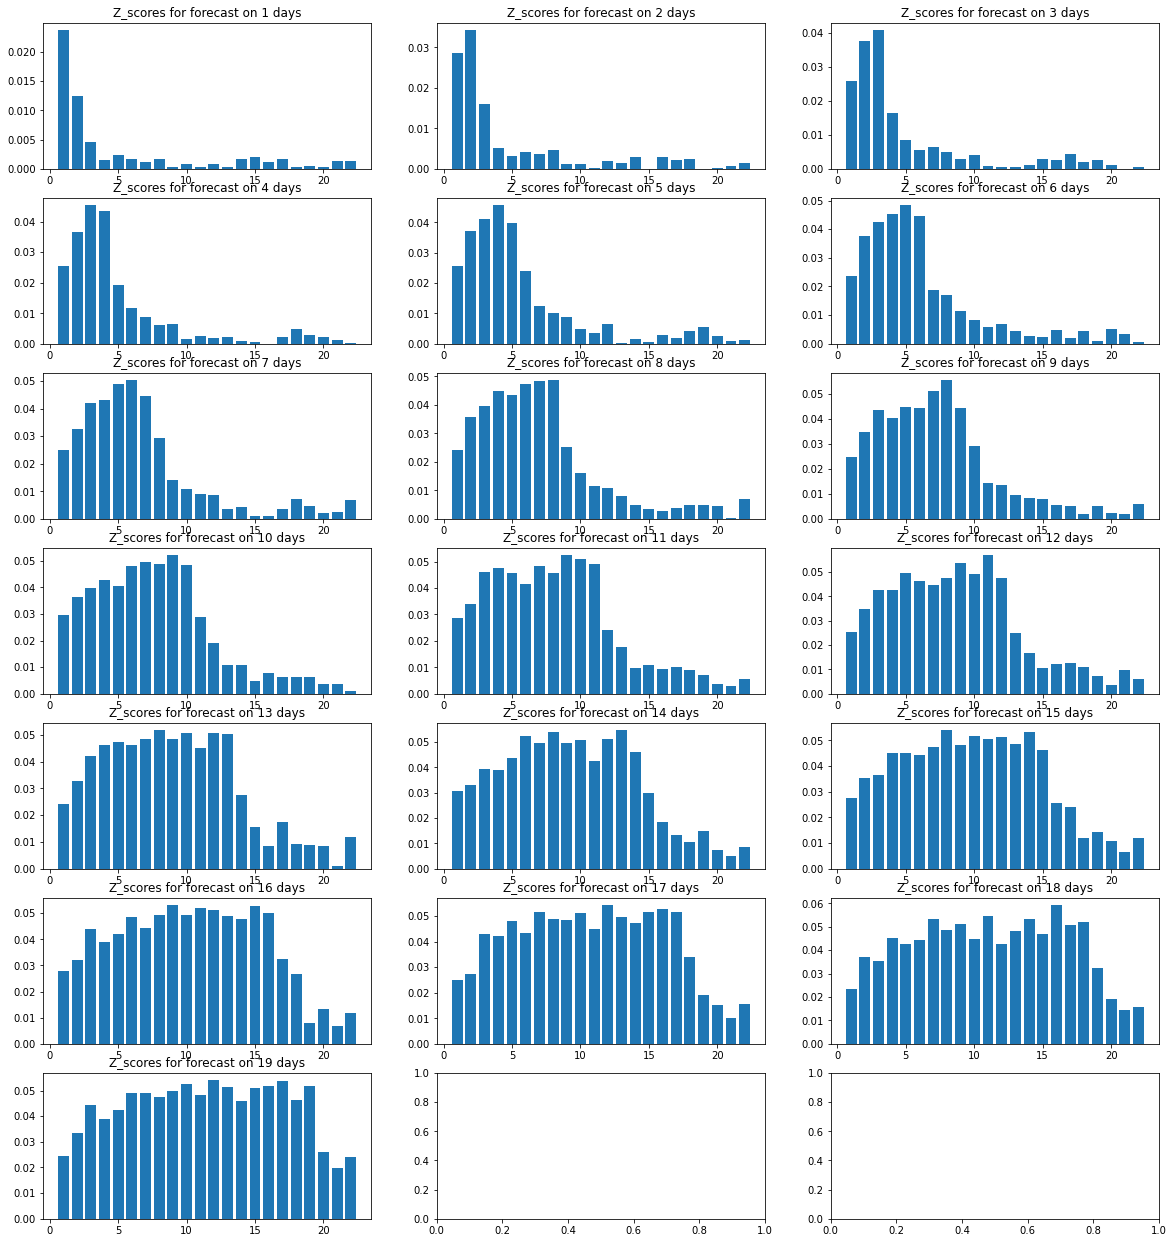

In [115]:
# Study the performance on different lapses of time
time_interval = list(range(1,20))
fig, axs = plt.subplots(nrows=7,ncols=3,figsize=(20,22))

for i in range(len(time_interval)):
    delta_days = time_interval[i]
    max_day_before = 22
    #delta_days = 5
    aquifer = pd.read_csv("../input/acea-water-prediction/Aquifer_Auser.csv")
    aquifer = format_date(aquifer)
    aquifer = format_rain(aquifer,max_day_before)
    aquifer = format_well(aquifer,"Depth_to_Groundwater_CoS", delta_days)
    #Delete initial rows with Nan values
    aquifer = aquifer.iloc[max_day_before-1:]


    #commented graph vor visualise the data
    #sns.scatterplot(data=aquifer, y="well_depth", x="day", hue="year" )

    # There are lots of non-recorded value. As we are mainly interested in estimating delta_depth
    # fill non recorded days by interpolation doesn't seem a good strategy, so we simply discard them
    aquifer = aquifer[aquifer["well_depth"]*aquifer["old_well_depth"]>0]


    # Now we need to separate data in train and test
    # Let's try with a shuffle (read comment below)
    train = aquifer.sample(frac=0.8,random_state=22) #random state is a seed value
    test = aquifer.drop(train.index)
    #We try predict the difference in depth level
    y_train = train["delta_depth"]
    y_test = test["delta_depth"]

    # Extracting features 
    features = extract_col(aquifer, 'tot_rain_') + ["old_well_depth","Temperature_Monte_Serra"]
    #take a subset of features, based on the performance of the total model
    # test error with all features: 0.0508
    # test error with  [0,1,2] features: 0.0516
    #selected_features = [features[i] for i in [0,1,2]]
    #features = extract_col(aquifer, 'Rainfall_') + ["old_well_depth"]
    selected_features = features
    #selected_features = [features[i] for i in [0,1,2]]
    #print("Features extracted: \n",selected_features)


    #extract and normalize training features

    x_train = train[selected_features]
    x_test = test[selected_features]
    x_train = normalize(x_train)
    x_test = normalize(x_test)

    #fitto il modello
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    reg = model.fit(x_train, y_train)
    std_errors = get_std_errors(x_train)
    print ("+"*40)
    print("Forecast on %d days.    R^2 = %2.3f"%(delta_days,reg.score(x_test, y_test))) 
    get_coef_table(reg, selected_features)
    
    z_scores = np.abs(reg.coef_[:-2]/std_errors[:-3])
    axs[i//3,i%3].bar(range(1,max_day_before+1), z_scores)
    axs[i//3,i%3].set_title("Z_scores for forecast on %d days"%delta_days)




plt.show()

# Importanza della pioggia passata in funzione del tempo

Il grafico seguente mostra l'importanza dei predittori (Z_score) nei vari modelli lineari a seconda dell'intervallo di tempo considerato.

Si osserva che l'impatto delle piogge sul livello del pozzo aumenta gradualmente col tempo (l'acqua devo poter fluire attraverso la falda) e raggiunge il suo massimo verso circa i 4-9 giorni 

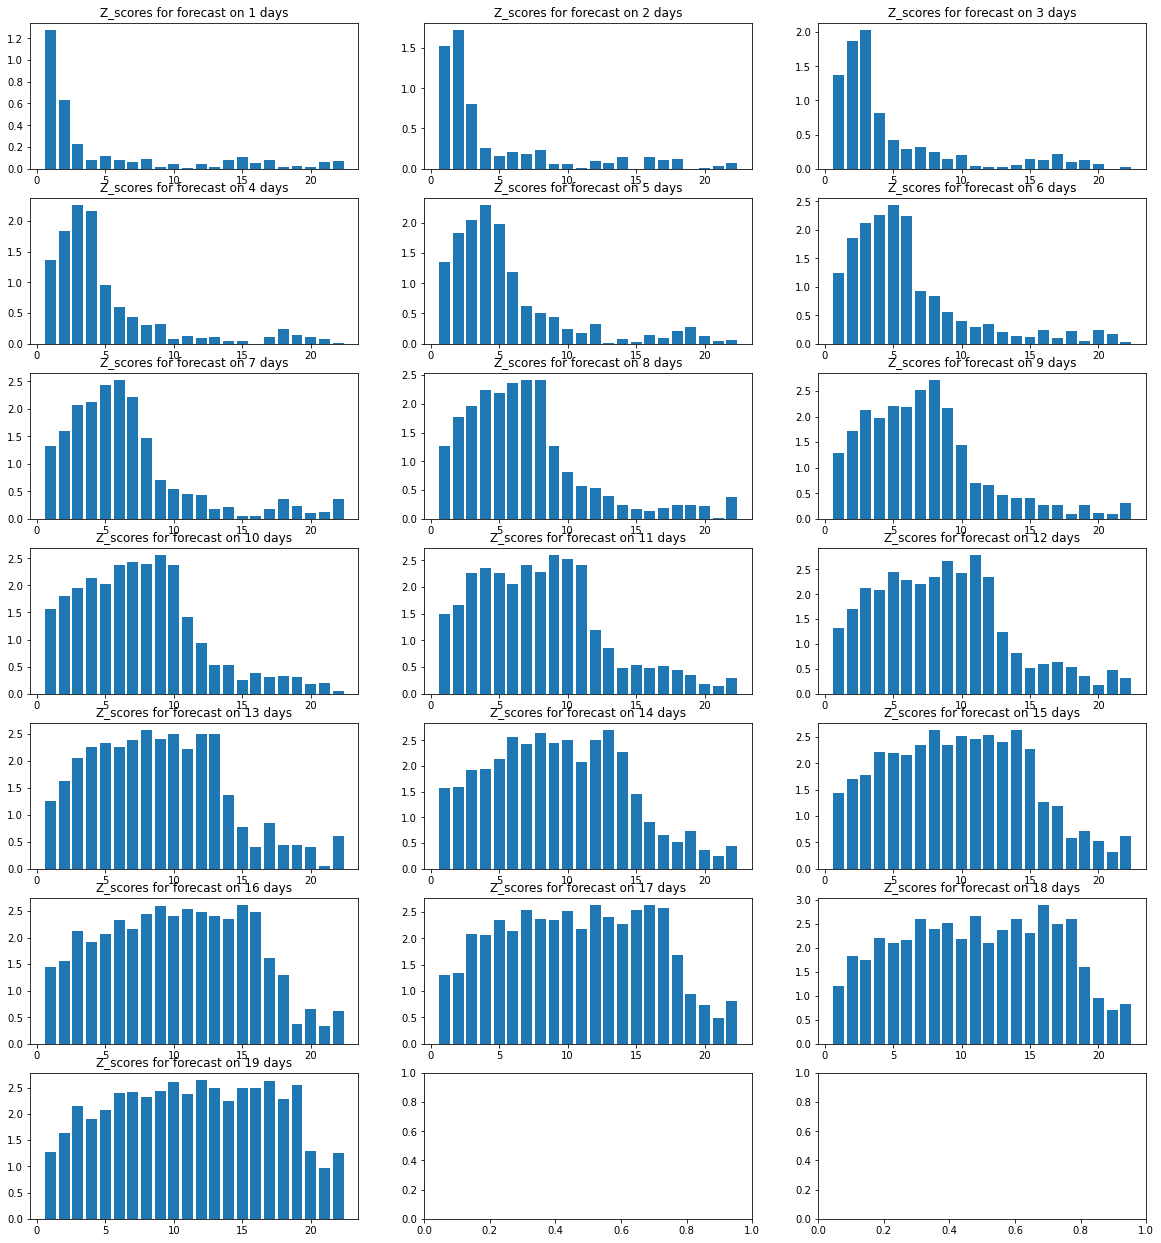****

# Previsioni su 10 giorni

Riprendiamo il nostro codice concentrandoci su un'intervallo di tempo di 10 giorni

Forecast on 200 days.    R^2 = 0.869
feature              |   coef | Z score
--------------------------------------
tot_rain_0           | -0.001 | -0.042
tot_rain_1           | +0.010 | +0.454
tot_rain_2           | +0.018 | +0.781
tot_rain_3           | +0.019 | +0.832
tot_rain_4           | +0.033 | +1.453
tot_rain_5           | +0.034 | +1.500
tot_rain_6           | +0.041 | +1.814
tot_rain_7           | +0.038 | +1.693
tot_rain_8           | +0.028 | +1.236
tot_rain_9           | +0.061 | +2.678
tot_rain_10          | +0.035 | +1.559
tot_rain_11          | +0.056 | +2.475
tot_rain_12          | +0.030 | +1.320
tot_rain_13          | +0.041 | +1.804
tot_rain_14          | +0.044 | +1.957
tot_rain_15          | +0.051 | +2.234
tot_rain_16          | +0.045 | +1.955
tot_rain_17          | +0.066 | +2.872
tot_rain_18          | +0.037 | +1.622
tot_rain_19          | +0.059 | +2.612
tot_rain_20          | +0.037 | +1.662
tot_rain_21          | +0.054 | +2.374
tot_rain_22          | +0.

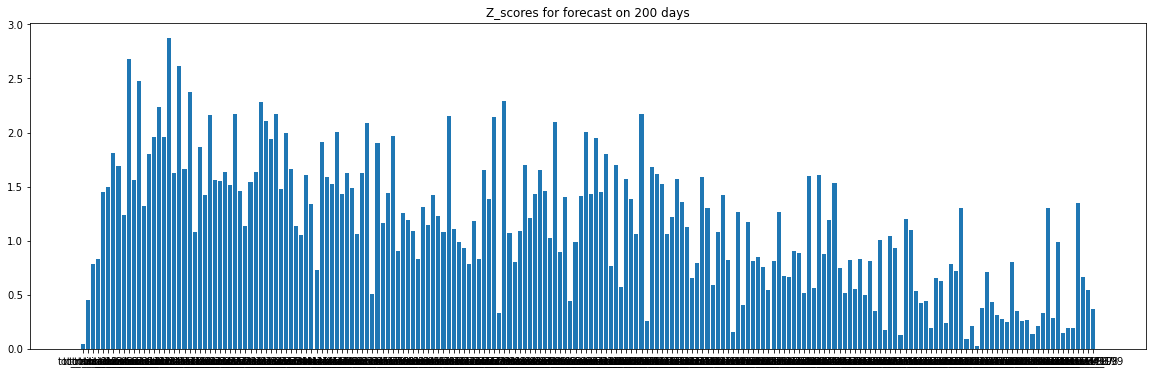

In [120]:


max_day_before = 200
delta_days = 200
aquifer = import_aquifer("auser")
aquifer = format_date(aquifer)
aquifer = format_rain(aquifer,max_day_before)
aquifer = format_well(aquifer,"Depth_to_Groundwater_CoS", delta_days)
#Delete initial rows with Nan values
aquifer = aquifer.iloc[max_day_before-1:]


#commented graph vor visualise the data
#sns.scatterplot(data=aquifer, y="well_depth", x="day", hue="year" )

# There are lots of non-recorded value. As we are mainly interested in estimating delta_depth
# fill non recorded days by interpolation doesn't seem a good strategy, so we simply discard them
aquifer = aquifer[aquifer["well_depth"]*aquifer["old_well_depth"]>0]


# Now we need to separate data in train and test
# Let's try with a shuffle (read comment below)
train = aquifer.sample(frac=0.8,random_state=22) #random state is a seed value
test = aquifer.drop(train.index)
#We try predict the difference in depth level
y_train = train["delta_depth"]
y_test = test["delta_depth"]

# Extracting features 
features = extract_col(aquifer, 'tot_rain_') + ["old_well_depth","Temperature_Monte_Serra"]
#take a subset of features, based on the performance of the total model
# test error with all features: 0.0508
# test error with  [0,1,2] features: 0.0516
#selected_features = [features[i] for i in [0,1,2]]
#features = extract_col(aquifer, 'Rainfall_') + ["old_well_depth"]
selected_features = features
#selected_features = [features[i] for i in [0,1,2]]
#print("Features extracted: \n",selected_features)


#extract and normalize training features

x_train = train[selected_features]
x_test = test[selected_features]
x_train = normalize(x_train)
x_test = normalize(x_test)

#fitto il modello
from sklearn.linear_model import LinearRegression
model = LinearRegression()
reg = model.fit(x_train, y_train)


std_errors = get_std_errors(x_train)
print("Forecast on %d days.    R^2 = %2.3f"%(delta_days,reg.score(x_test, y_test))) 
get_coef_table(reg, selected_features)

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
z_scores = np.abs(reg.coef_[:-2]/std_errors[:-3])
axs.bar(selected_features[:-2], z_scores)
axs.set_title("Z_scores for forecast on %d days"%delta_days)
plt.show()

In [54]:
def get_std_errors(X_old):
    X = X_old.copy()
    X["intercept"] = 1
    df = X.transpose().dot(X)
    inv = pd.DataFrame(np.linalg.pinv(df.values), df.columns, df.index)
    return np.sqrt(np.diag(inv))

# Print coeff and Z score as a table
def get_coef_table(reg, features):
    format = "%-20s | %+2.3f | %+2.3f"
    format_title = "%-20s | %6s | %6s"
    print (format_title %("feature","coef","Z score"))
    print ("-"*38)
    for i in range((len(features))):
        print(format%(features[i][:20],reg.coef_[i],reg.coef_[i]/std_errors[i]))
    print("Intercept:\n", reg.intercept_)

std_errors = get_std_errors(x_train)
print("Forecast on %d days.    R^2 = %2.3f"%(delta_days,reg.score(x_test, y_test))) 
get_coef_table(reg, selected_features)



Forecast on 3 days.    R^2 = 0.486
feature              |   coef | Z score
--------------------------------------
tot_rain_0           | +0.026 | +1.373
tot_rain_1           | +0.038 | +1.893
tot_rain_2           | +0.041 | +2.047
tot_rain_3           | +0.017 | +0.848
tot_rain_4           | +0.008 | +0.423
tot_rain_5           | +0.006 | +0.285
tot_rain_6           | +0.007 | +0.334
tot_rain_7           | +0.005 | +0.244
tot_rain_8           | +0.003 | +0.149
tot_rain_9           | +0.005 | +0.240
old_well_depth       | -0.035 | -1.778
Temperature_Monte_Se | -0.038 | -1.856
Intercept:
 -0.1601648601379892


(732312.0, 737791.0)

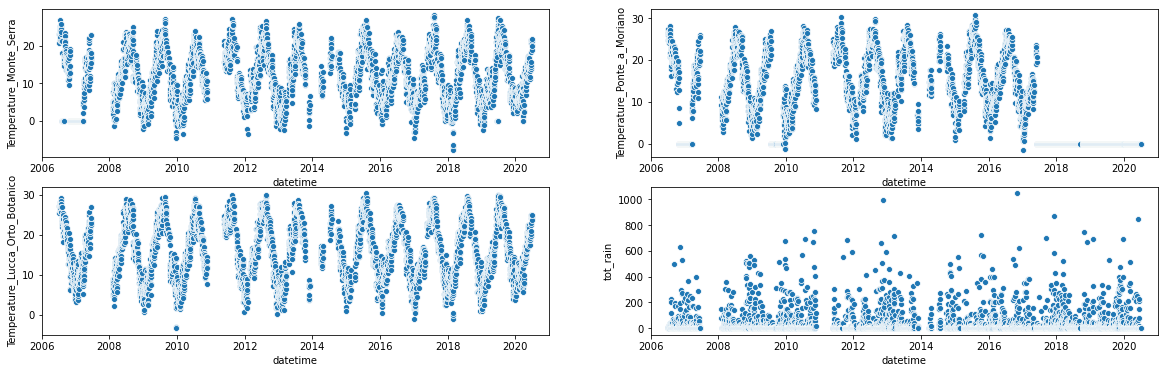

In [117]:
# Graphing temperatures
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,6))
sns.scatterplot(data=aquifer, y="Temperature_Monte_Serra", x="datetime" ,ax=axs[0,0])
sns.scatterplot(data=aquifer, y="Temperature_Ponte_a_Moriano", x="datetime" ,ax=axs[0,1])
sns.scatterplot(data=aquifer, y="Temperature_Lucca_Orto_Botanico", x="datetime" ,ax=axs[1,0])
sns.scatterplot(data=aquifer, y="tot_rain", x="datetime" ,ax=axs[1,1])
axs[0,0].set_xlim(datetime.datetime(2006,1,1),datetime.datetime(2021,1,1))
axs[0,1].set_xlim(datetime.datetime(2006,1,1),datetime.datetime(2021,1,1))
axs[1,0].set_xlim(datetime.datetime(2006,1,1),datetime.datetime(2021,1,1))
axs[1,1].set_xlim(datetime.datetime(2006,1,1),datetime.datetime(2021,1,1))
# Temperature_Ponte_a_Moriano = 0.00% 
#NaN values in Temperature_Lucca_Orto_Botanico
 

In [26]:

aquifer

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,tot_rain_4,tot_rain_5,tot_rain_6,tot_rain_7,tot_rain_8,tot_rain_9,tot_rain_10,well_depth,old_well_depth,delta_depth
3047,08/07/2006,34.8,0.0,1.4,14.6,10.0,21.4,2.8,43.6,0.0,...,11.4,10.2,1.2,2.0,1.4,0.2,0.8,-6.78,-6.43,-0.35
3048,09/07/2006,0.0,0.0,0.4,0.0,0.0,0.0,0.0,1.2,8.4,...,0.0,11.4,10.2,1.2,2.0,1.4,0.2,-6.80,-6.46,-0.34
3049,10/07/2006,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,...,6.2,0.0,11.4,10.2,1.2,2.0,1.4,-6.79,-6.50,-0.29
3050,11/07/2006,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,86.4,6.2,0.0,11.4,10.2,1.2,2.0,-6.80,-6.55,-0.25
3051,12/07/2006,0.0,0.0,0.2,0.0,2.8,0.0,0.0,0.0,0.0,...,140.8,86.4,6.2,0.0,11.4,10.2,1.2,-6.75,-6.60,-0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8148,25/06/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.2,0.2,0.6,228.2,81.4,31.4,-5.59,-5.50,-0.09
8150,27/06/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.4,0.2,0.2,0.6,228.2,-5.71,-5.37,-0.34
8151,28/06/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.4,0.2,0.2,0.6,-5.73,-5.33,-0.40
8152,29/06/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.4,0.2,0.2,-5.73,-5.37,-0.36


In [29]:
selected_features = [features[i] for i in [0,1,2,-1]]
selected_features

['tot_rain_0', 'tot_rain_1', 'tot_rain_2', 'temp3']

**Perché lo shuffle?**
Nel corso degli anni le proprietà idrografiche sono mutate, il che è provato per esempio dall'evoluzione delle curve di correlazione tra i diversi bacini. Quindi il modello, lungi dall'essere immutabile, dipende dall'anno preso in esame.
Queste considerazioni sono in contraddizione con il fatto di esaminare tutti gli anni indistintamente. In ogni caso questa idea deve essere necessariamente testata, essendo quella più semplice.
In ogni caso, lo shuffle ci permette almeno di testare il modello in modo imparziale, senza considerare la correlazione temporale


I think that old_well_depth is a non_linear feature, as water drainage is generally non_linear so we can use a spline for it

In [30]:
#Extract the output for train and test
y = train["y"]
y_test = test["y"]
print("Possible outputs counting:\n",pd.Series.value_counts(y)) 

#Extract the features
features = ["x.1", "x.2", "x.3", "x.4", "x.5", "x.6", "x.7", "x.8", "x.9", "x.10"]
X = train_norm[features]
X_test = test_norm[features]

KeyError: 'y'

In [ ]:
for df in (auser, doganella):
    print("_____________________")
    for col in df.columns:
        print("NaN values in %s = %2.2f%% " % (col, 100*df[col].isnull().sum()/df.shape[0]))


In [ ]:
auser.dtypes

In [ ]:
auser = pd.read_csv("../input/acea-water-prediction/Aquifer_Auser.csv")
auser = auser.fillna(1)
print(auser.Hydrometry_Piaggione.isnull().sum())
print(auser.Hydrometry_Monte_S_Quirico.isnull().sum())

auser["year"] = pd.DatetimeIndex(auser['Date']).year
auser["datetime"] = auser['Date'].apply(lambda x: pd.to_datetime(x) )
auser['ElapsedTime'] = (auser['datetime'] - auser['datetime'].iloc[0]).astype("timedelta64[h]")

print(auser.datetime)

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
sns.scatterplot(data=auser[auser.year==2019], y="Depth_to_Groundwater_DIEC", x="Depth_to_Groundwater_CoS", hue="year" )
plt.show()



In [ ]:
wells_name = [col for col in auser.columns if col[0:6]=='Depth_']
wells = auser[wells_name]
wells_corr = wells.corr(method='pearson')
sns.heatmap(wells_corr)
print(wells_corr)
print("Between correlations:")
print(wells_corr.mean())
print("Standard deviation of values")
print(wells.std())